In [1]:
import torch
from torch.utils.data import Dataset
from torchvision.transforms import Normalize, v2
from torchvision import tv_tensors
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt

In [2]:
def lin_indices(original_length, subsampled_length):
    indices = np.linspace(0, original_length - 1, subsampled_length + 1, dtype=int)
    return indices[1:]

def uniform_biosensor(biosensor):
    indices = lin_indices(biosensor.shape[0], 8)
    # if self.input_scaling == False:
    return biosensor[indices]
    # downsampled_bio = biosensor[indices]
    # upscaled = torch.nn.functional.interpolate(downsampled_bio.unsqueeze(0), size=(self.mask_size, self.mask_size), mode=self.upscale_mode).squeeze(0)
    # return upscaled
    
def uniform_mask(mask, centers):
    interpolated_mask = torch.nn.functional.interpolate(mask.unsqueeze(0).unsqueeze(0).float(), size=(320, 320), mode='nearest').squeeze(0).squeeze(0).byte()
    
    # x_scale = mask.shape[0] / 80
    # y_scale = mask.shape[1] / 80
    
    # scaled_centers = centers / [x_scale, y_scale]

    # # Add the cell centers to the mask
    # indices = np.transpose(scaled_centers.astype(int))
    # interpolated_mask[indices[0], indices[1]] = True
    
    return interpolated_mask

In [10]:
def create_tiles(bio, mask, ratio, overlap_rate=0):
    ch, bio_h, bio_w = bio.shape
    mask_h, mask_w = mask.shape
    bio_size = bio_h // ratio
    mask_size = mask_h // ratio
    # print(bio_size, mask_size)

    bio_stride = bio_size - int(bio_size * overlap_rate)
    mask_stride = mask_size - int(mask_size * overlap_rate)
    # print(bio_stride, mask_stride)

    bio_tiles = bio.unfold(1, bio_size, bio_stride).unfold(2, bio_size, bio_stride)
    # print(bio_tiles.shape)
    bio_tiles = bio_tiles.permute(1, 2, 0, 3, 4).reshape(-1, ch, bio_size, bio_size)
    mask_tiles = mask.unfold(0, mask_size, mask_stride).unfold(1, mask_size, mask_stride)
    # print(mask_tiles.shape)
    mask_tiles = mask_tiles.permute(0, 1, 2, 3).reshape(-1, mask_size, mask_size)

    return bio_tiles, mask_tiles


In [59]:
def merge_tiles(tiles, original_size, overlap_rate=0):
    num_tiles, tile_size, _ = tiles.shape
    stride = tile_size - int(tile_size * overlap_rate)
    ratio = original_size // tile_size

    merged = torch.zeros(original_size, original_size)
    contribution_map = torch.zeros(original_size, original_size)

    idx = 0
    for i in range(0, original_size - tile_size + 1, stride):
        for j in range(0, original_size - tile_size + 1, stride):
            merged[i:i + tile_size, j:j + tile_size] += tiles[idx]
            contribution_map[i:i + tile_size, j:j + tile_size] += 1
            idx += 1

    # Handle any edge cases for the last row/column of tiles
    if i + tile_size < original_size:
        for j in range(0, original_size - tile_size + 1, stride):
            merged[original_size - tile_size:, j:j + tile_size] += tiles[idx]
            contribution_map[original_size - tile_size:, j:j + tile_size] += 1
            idx += 1

    if j + tile_size < original_size:
        for i in range(0, original_size - tile_size + 1, stride):
            merged[i:i + tile_size, original_size - tile_size:] += tiles[idx]
            contribution_map[i:i + tile_size, original_size - tile_size:] += 1
            idx += 1

    merged /= contribution_map
    return merged

torch.Size([25, 8, 20, 20]) torch.Size([25, 80, 80])


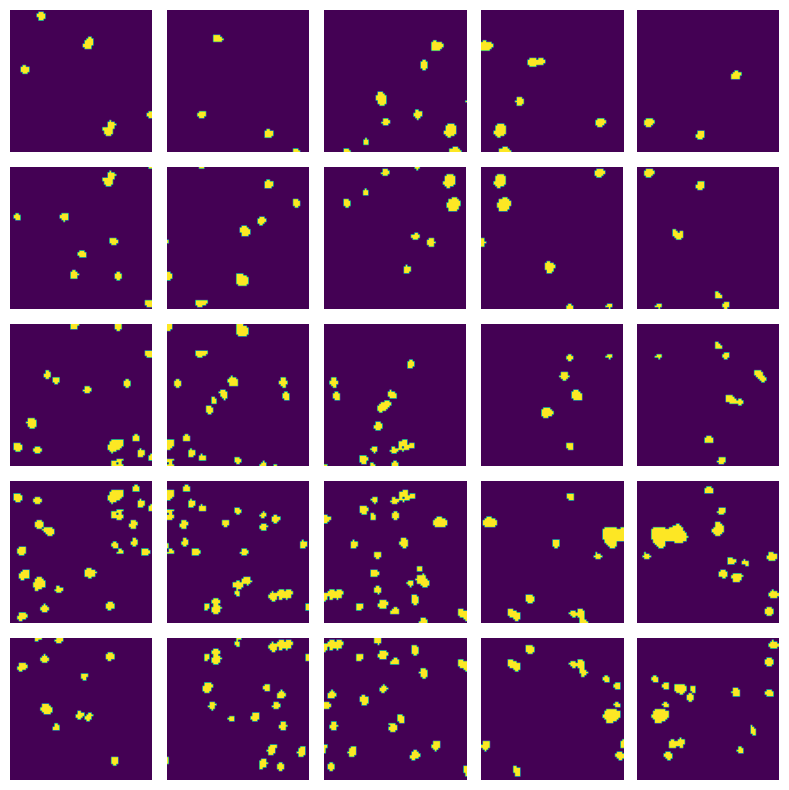

torch.Size([320, 320])


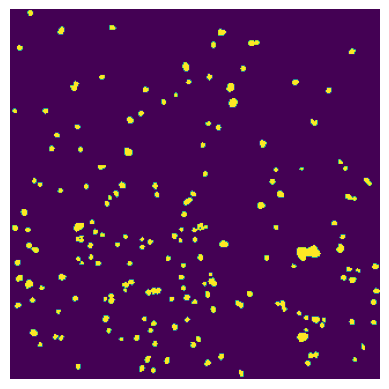

In [62]:
data = np.load('C:/onlab_git/Onlab/data_with_centers/20.npz')
bio = uniform_biosensor(torch.from_numpy(data['biosensor'].astype(np.float32)))
mask = uniform_mask(torch.from_numpy(data['mask'].astype(bool)), data['cell_centers'])
overlap_rate = 0.25
bio_tile, mask_tiles = create_tiles(bio, mask, 4, overlap_rate)
print(bio_tile.shape, mask_tiles.shape)
tiles, ch, h, w = bio_tile.shape
x = int(np.sqrt(tiles))
fig, ax = plt.subplots(x, x, figsize=(8, 8))
for i in range(x):
    for j in range(x):
        ax[i, j].imshow(mask_tiles[j + i * x])
        ax[i, j].axis('off')
plt.tight_layout()
plt.show()

mask_merged = merge_tiles(mask_tiles, 320, overlap_rate)
print(mask_merged.shape)
plt.imshow(mask_merged)
plt.axis('off')
plt.show()

In [13]:
# the tiles are masks or predictions 
# which have dimensions as (n, 80, 80) where n is the number of tiles
def merge_tiles(tiles):
    n, h, w = tiles.shape
    ratio = int(np.sqrt(n))
    merged = tiles.reshape(ratio, ratio, h, w).permute(0, 2, 1, 3).reshape(ratio * h, ratio * w)
    return merged

def create_tiles(bio, mask, ratio):
    ch, bh, bw = bio.shape
    mh, mw = mask.shape
    bio_size = bh // ratio
    mask_size = mh // ratio

    bio_tiles = bio.reshape(ch, ratio, bio_size, ratio, bio_size).permute(1, 3, 0, 2, 4).reshape(ratio * ratio, ch, bio_size, bio_size)
    mask_tiles = mask.reshape(ratio, mask_size, ratio, mask_size).permute(0, 2, 1, 3).reshape(ratio * ratio, mask_size, mask_size)
    # print(bio_tiles.shape, mask_tiles.shape)

    return bio_tiles, mask_tiles

# pachify?
def create_overlapping_tiles(bio, mask, tile_size, stride):
    ch, bh, bw = bio.shape
    mh, mw = mask.shape

    # Use unfold to create sliding windows
    bio_unfolded = bio.unfold(1, tile_size, stride).unfold(2, tile_size, stride)
    mask_unfolded = mask.unfold(0, tile_size, stride).unfold(1, tile_size, stride)

    # Get the number of tiles
    num_tiles_h = bio_unfolded.size(1)
    num_tiles_w = bio_unfolded.size(2)

    # Reshape to get the tiles in the desired format
    bio_tiles = bio_unfolded.permute(1, 2, 0, 3, 4).reshape(num_tiles_h * num_tiles_w, ch, tile_size, tile_size)
    mask_tiles = mask_unfolded.reshape(num_tiles_h * num_tiles_w, tile_size, tile_size)

    return bio_tiles, mask_tiles

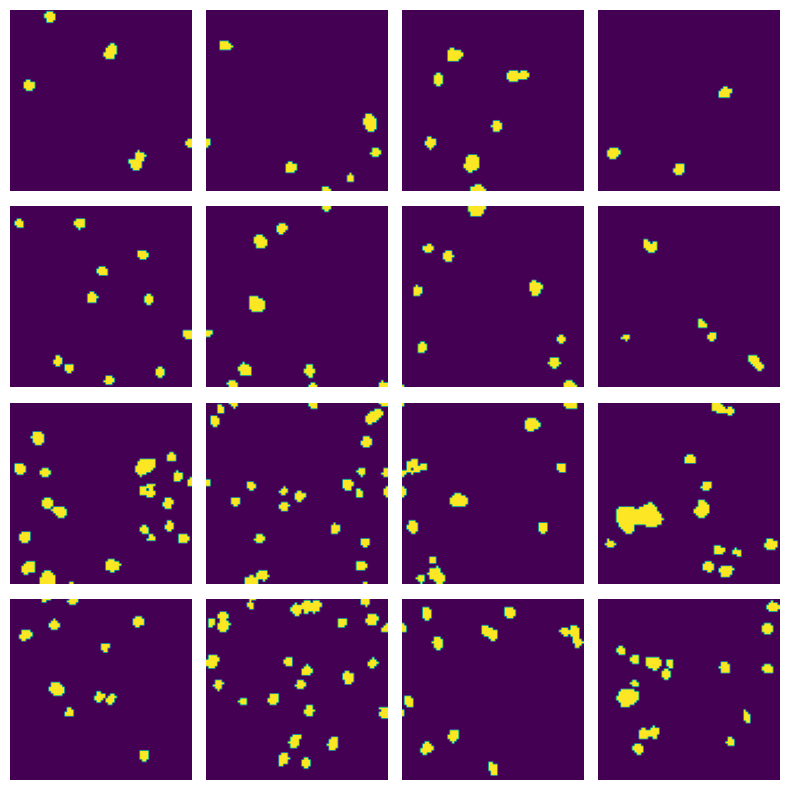

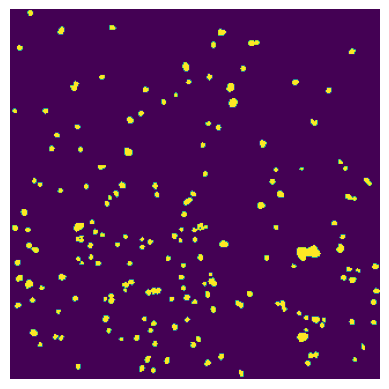

In [14]:
data = np.load('C:/onlab_git/Onlab/data_with_centers/20.npz')
bio = uniform_biosensor(torch.from_numpy(data['biosensor'].astype(np.float32)))
mask = uniform_mask(torch.from_numpy(data['mask'].astype(bool)), data['cell_centers'])
bio_tile, mask_tiles = create_tiles(bio, mask, 4)

fig, ax = plt.subplots(4, 4, figsize=(8, 8))
for i in range(4):
    for j in range(4):
        ax[i, j].imshow(mask_tiles[j + i * 4])
        ax[i, j].axis('off')
plt.tight_layout()
plt.show()

mask_merged = merge_tiles(mask_tiles)
plt.imshow(mask_merged)
plt.axis('off')
plt.show()

In [68]:
def create_tiles(bio, mask, tile_size):
    ch, h, w = bio.shape
    new_h = h // tile_size
    new_w = w // tile_size

    bio_tiles = bio.reshape(ch, new_h, tile_size, new_w, tile_size).permute(1, 3, 0, 2, 4).reshape(new_h * new_w, ch, tile_size, tile_size)
    mask_tiles = mask.reshape(new_h, tile_size, new_w, tile_size).permute(0, 2, 1, 3).reshape(new_h * new_w, tile_size, tile_size)
    print(bio_tiles.shape, mask_tiles.shape)

    return bio_tiles, mask_tiles

data = np.load('C:/onlab_git/Onlab/data_with_centers/20.npz')
bio = uniform_biosensor(torch.from_numpy(data['biosensor'].astype(np.float32)))
mask = uniform_mask(torch.from_numpy(data['mask'].astype(bool)), data['cell_centers'])
bio_tile, mask_tiles = create_tiles(bio, mask, 20)

# fig, ax = plt.subplots(8, 16, figsize=(16, 8))
# for i in range(8):
#     for j in range(16):
#         ax[i, j].imshow(bio_tiles[j, i])
#         ax[i, j].axis('off')
# plt.show()

# fig, ax = plt.subplots(4, 4, figsize=(8, 8))
# for i in range(4):
#     for j in range(4):
#         ax[i, j].imshow(mask_tiles[j + i * 4])
#         ax[i, j].axis('off')
# plt.tight_layout()
# plt.show()

torch.Size([16, 8, 20, 20]) torch.Size([16, 20, 20])


torch.Size([16, 8, 20, 20])


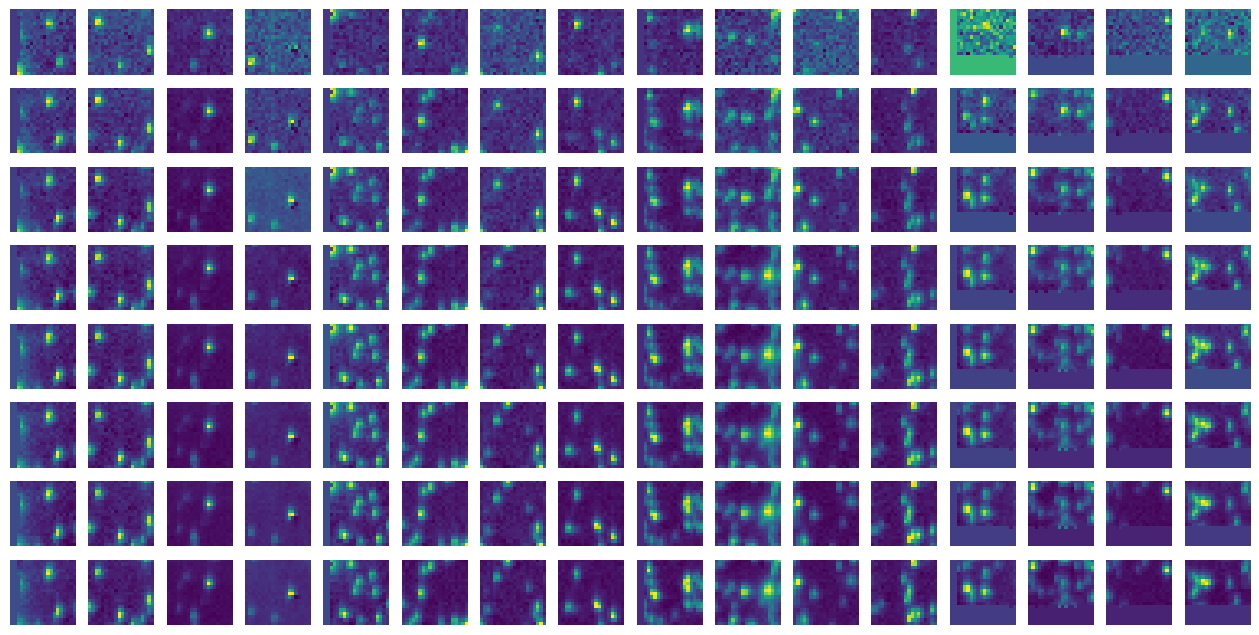

In [51]:
def create_tiles(tensor, tile_size):
    ch, h, w = tensor.shape

    # tiles = tensor.reshape(ch, h // tile_size, tile_size, w // tile_size, tile_size).swapaxes(2, 3).reshape(ch, (h // tile_size) * (w // tile_size), tile_size, tile_size).swapaxes(0, 1)
    # print(tiles.shape)

    tiles = tensor.reshape(ch, h // tile_size, tile_size, w // tile_size, tile_size).permute(1, 3, 0, 2, 4).reshape((h // tile_size) * (w // tile_size), ch, tile_size, tile_size)
    print(tiles.shape)

    return tiles

# hogyan lehet az egyes tileokat teljes chanellel kiszedni?
# ha az input 8x80x80 akkor a kimenet 16x8x20x20 ha 20 a tile size
data = np.load('C:/onlab_git/Onlab/data_with_centers/20.npz')
bio = uniform_biosensor(torch.from_numpy(data['biosensor'].astype(np.float32)))
mask = uniform_mask(torch.from_numpy(data['mask'].astype(bool)), data['cell_centers'])
tiles = create_tiles(bio, 20)

fig, ax = plt.subplots(8, 16, figsize=(16, 8))
for i in range(8):
    for j in range(16):
        ax[i, j].imshow(tiles[j, i])
        ax[i, j].axis('off')
plt.show()


# fig, ax = plt.subplots(8, figsize=(16, 8))
# for i in range(8):
#     ax[i].imshow(tiles[i, 5])
#     ax[i].axis('off')
# plt.show()

torch.Size([8, 80, 80]) torch.Size([80, 80])
torch.Size([16, 8, 20, 20]) torch.Size([16, 20, 20])


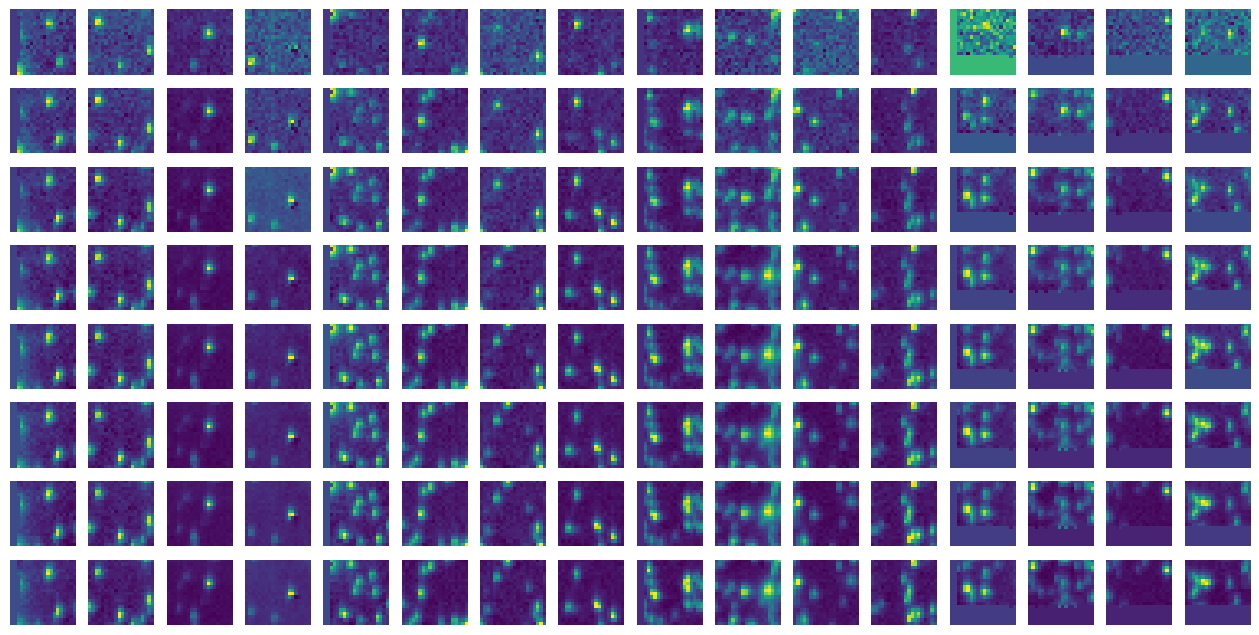

In [43]:
data = np.load('C:/onlab_git/Onlab/data_with_centers/20.npz')
bio = uniform_biosensor(torch.from_numpy(data['biosensor'].astype(np.float32)))
mask = uniform_mask(torch.from_numpy(data['mask'].astype(bool)), data['cell_centers'])
# bio = self.normalize(bio)
# if self.transform:
#     mask = tv_tensors.Mask(mask)
#     bio, mask = self.transform(bio, mask)

print(bio.shape, mask.shape)

# Reshape bio to 4x20x4x20 and then swap axes to get 16x20x20 tiles
bio_tiles = bio.reshape(8, 4, 20, 4, 20).swapaxes(2, 3).reshape(8, 16, 20, 20).swapaxes(0, 1)

# Reshape mask to 4x20x4x20 and then swap axes to get 16x20x20 tiles
mask_tiles = mask.reshape(4, 20, 4, 20).swapaxes(1, 2).reshape(16, 20, 20)


print(bio_tiles.shape, mask_tiles.shape)

fig, ax = plt.subplots(8, 16, figsize=(16, 8))
for i in range(8):
    for j in range(16):
        ax[i, j].imshow(bio_tiles[j, i])
        ax[i, j].axis('off')
plt.show()

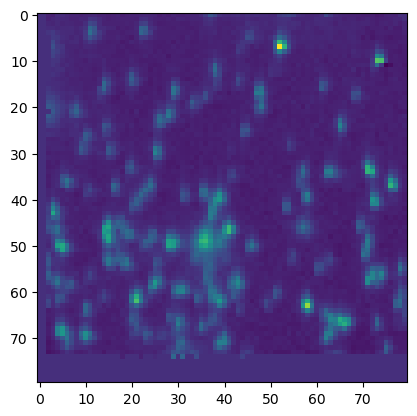

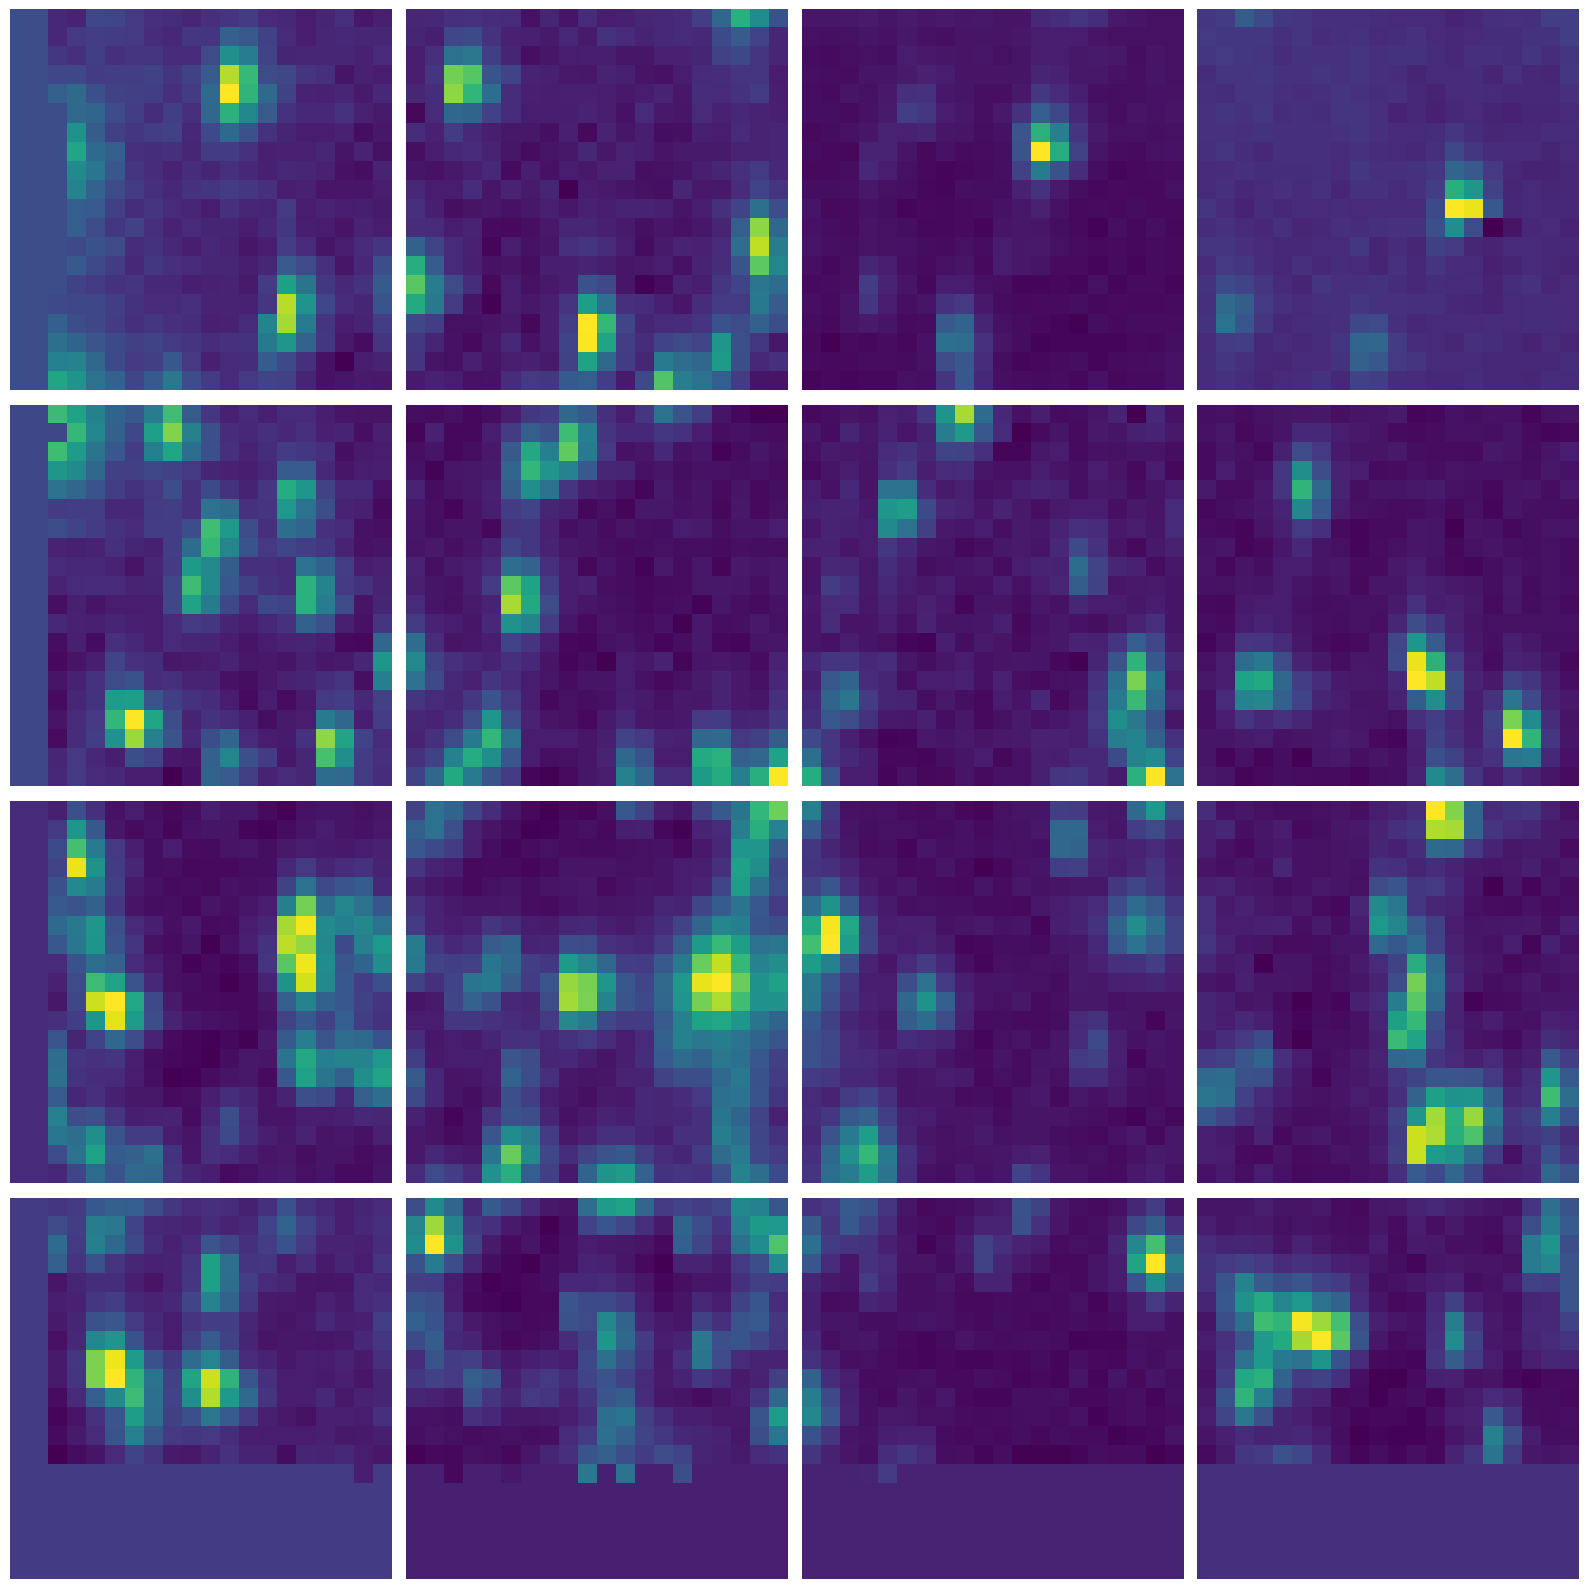

In [37]:
selected_bio_tiles = bio_tiles[112:128]
selected_mask_tiles = mask_tiles[:16]

plt.imshow(bio[-1])
# plt.imshow(mask)
plt.show()


fig, ax = plt.subplots(4, 4, figsize=(16, 16))
for i in range(4):
    for j in range(4):
        idx = i * 4 + j
        ax[i, j].imshow(selected_bio_tiles[idx])
        # ax[i, j].imshow(selected_mask_tiles[idx], alpha=0.5)
        ax[i, j].axis('off')
plt.tight_layout()
plt.show()

torch.Size([80, 80]) torch.Size([80, 80])
torch.Size([64, 10, 10]) torch.Size([64, 10, 10])


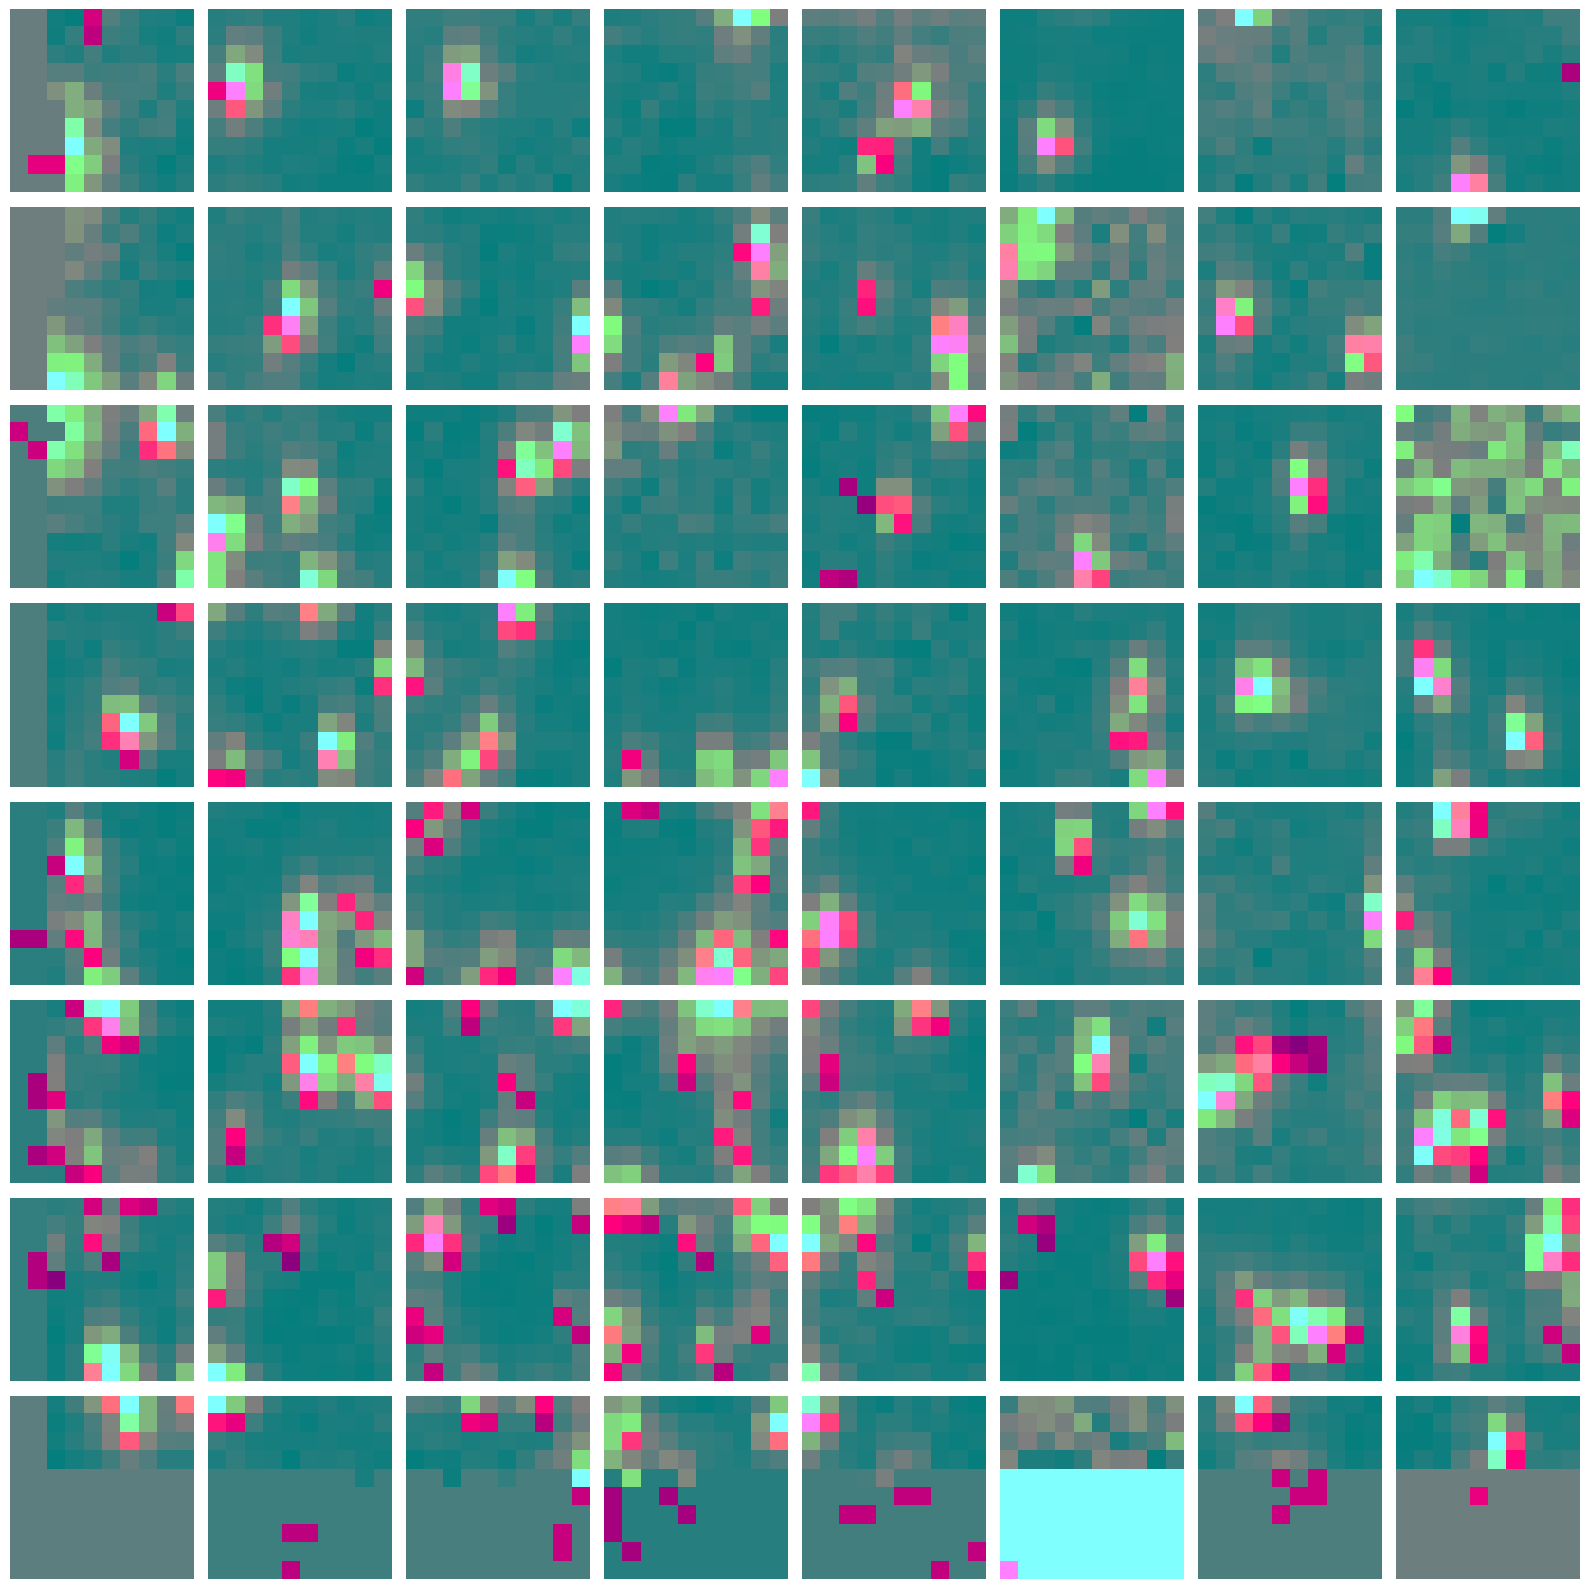

In [40]:
import numpy as np
import torch
import matplotlib.pyplot as plt

# Load data
data = np.load('C:/onlab_git/Onlab/data_with_centers/20.npz')
bio = uniform_biosensor(torch.from_numpy(data['biosensor'].astype(np.float32)))
mask = uniform_mask(torch.from_numpy(data['mask'].astype(bool)), data['cell_centers'])

# Define tile size
tile_size = 10

# Extract only the last channel of bio
bio = bio[-1]

print(bio.shape, mask.shape)  # Verify the shapes

# Calculate the number of tiles per row and column
num_tiles_per_row = bio.shape[0] // tile_size
num_tiles_per_col = bio.shape[1] // tile_size

# Reshape bio to num_tiles_per_row x tile_size x num_tiles_per_col x tile_size and then swap axes
bio_tiles = bio.reshape(num_tiles_per_row, tile_size, num_tiles_per_col, tile_size).swapaxes(1, 2).reshape(num_tiles_per_row * num_tiles_per_col, tile_size, tile_size)

# Reshape mask to num_tiles_per_row x tile_size x num_tiles_per_col x tile_size and then swap axes
mask_tiles = mask.reshape(num_tiles_per_row, tile_size, num_tiles_per_col, tile_size).swapaxes(1, 2).reshape(num_tiles_per_row * num_tiles_per_col, tile_size, tile_size)

print(bio_tiles.shape, mask_tiles.shape)

# Determine the number of columns for the grid
num_cols = 8  # Number of columns in the grid
num_rows = num_tiles_per_row * num_tiles_per_col // num_cols  # Number of rows in the grid

fig, ax = plt.subplots(num_rows, num_cols, figsize=(16, 16))
for i in range(num_rows):
    for j in range(num_cols):
        idx = i * num_cols + j
        ax[i, j].imshow(bio_tiles[idx], cmap='hot')
        ax[i, j].imshow(mask_tiles[idx], cmap='cool', alpha=0.5)
        ax[i, j].axis('off')
plt.tight_layout()
plt.show()